<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px">

## Timeseries modeling with LSTM neural networks

Week 12 | Lesson 2.2

---

Modeling timeseries with neural network architecture is a widely growing trend. In particular, the Long Short Term Memory (LSTM) recurrent neural network is a common choice as it is designed to maintain "context" or memory of temporal events.

In this lecture/lab we will be building an LSTM using Keras to forecast timeseries data. 

[This tutorial also provides a great introduction to building a simple LSTM for timeseries forecasting.](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) which 

Two great resources on neural network architecture and LSTMs can be found here as well:

http://deeplearning4j.org/lstm.html#a-beginners-guide-to-recurrent-networks-and-lstms

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

### Load Keras modules

We are going to be loading four classes from oKeras:

- **`Sequential`** is the model that will house our neural network layers. It stacks together the input, "hidden" and output layers of the network.
- **`Dense`** is a standard fully-connected neural network layer where each node as inputs/output connections to every node in the layers it is connected to.
- **`LSTM`** is the Long Short Term Memory recurrent neural network layer. This will house our LSTM "neurons" or "cells".

We are also importing `MinMaxScaler` from sklearn since inputs to the LSTM perform better if they are kept on a 0-1 scale.

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


---

### Modeling the unemployment data with an LSTM



In [28]:
data = pd.read_csv('/Users/kiefer/github-repos/DSI-SF-4/datasets/unemployment_timeseries/seasonally-adjusted-quarterly-us.csv')

In [29]:
data.columns = ['year_quarter', 'unemployment_rate']
data['unemployment_rate'] = data['unemployment_rate'].map(lambda x: float(str(x).replace('%','')))
data['udiff'] = data['unemployment_rate'].diff()
data.dropna(inplace=True)

In [30]:
urate = data[['udiff']]
mms = MinMaxScaler(feature_range=(-1, 1))
urate = mms.fit_transform(urate)
print urate.shape

(173, 1)


---

### Split the timeseries into 50% train/test splits

In [31]:
train_size = int(len(urate) * 0.50)
test_size = len(urate) - train_size
print len(urate), train_size, test_size

train, test = urate[0:train_size,:], urate[train_size:len(urate),:]

173 86 87


---

### Write a function to create our predictor and target data

Our function will need to create a Y target and X predictor. The X predictor matrix will be the shifted versions of Y, our target unemployment timeseries.

Make a function with two arguments:

1. The timeseries data.
2. The number of lags of the timeseries to have as predictors.

This default will create a dataset where X is the unemployment rate a given time (t) and Y is the unemployment rate at the next time (t + 1). In other words, at the default lag of 1 X will just be the unemployment timeseries of Y shifted back by 1.

Make sure that in the end X and Y are of the same length!

In [32]:
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    for i in range(data.shape[0]-look_back-1):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [33]:
X, Y = create_dataset(train)

In [34]:
print X[0:10]

[[-0.31636916]
 [-0.19027725]
 [-0.2161033 ]
 [ 0.36726168]
 [ 0.64527155]
 [ 0.36650209]
 [-0.06342575]
 [-0.69692366]
 [-0.89897455]
 [-0.97569313]]


In [35]:
print Y[0:10]

[-0.19027725 -0.2161033   0.36726168  0.64527155  0.36650209 -0.06342575
 -0.69692366 -0.89897455 -0.97569313 -0.57007216]


---

### Create training and testing data for a lag of 1

Again, this means our X will just have 1 column.

In [36]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

---

### Reshaping the data to work with the LSTM

The layout the LSTM expects for our data is:

    [samples, time_steps, features]
    
A 3D matrix.

Currently our X predictor matrix is in the form 

    [samples, features]
    
Where we have one time step per feature per sample.

You can use the `np.reshape()` command to turn your 2D X matrix into a 3D matrix that works for the LSTM matrix. We will talk about the "time step" dimension more down the line.

In [37]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [38]:
print trainX.shape

(84, 1, 1)


---

### Constructing the Keras model

Our LSTM model will be constructed in three parts.

First initialize the sequential layer-to-layer neural network model:

```python
model = Sequential()
```
    
Add an LSTM layer with 4 blocks/cells/neurons. We specify the `input_dim` to be the same dimensions as our number of features. In our current scenario this is just our single timeseries of the 1-lag previous unemployment rate:

```python
model.add(LSTM(4, input_dim=1))
```

Add the output layer as a layer of one neuron that is fully connected to all of the previous LSTM cells:

```python
model.add(Dense(1))
```

In [39]:
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))


---

### Fit the LSTM model

We can fit the model with these commands:

```python
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)
```

Which will use the squared error loss (regression) and fit the data over 100 "epochs", or passes over the training data. It makes multiple passes because these LSTM neural networks learn according to a learning rate (which we have not specified).

In [40]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=20, batch_size=1, verbose=1)

Epoch 1/20
84/84 [==============================] - 2s - loss: 0.2224     
Epoch 2/20
84/84 [==============================] - 0s - loss: 0.1701     
Epoch 3/20
84/84 [==============================] - 0s - loss: 0.1393     
Epoch 4/20
84/84 [==============================] - 0s - loss: 0.1226     
Epoch 5/20
84/84 [==============================] - 0s - loss: 0.1133     
Epoch 6/20
84/84 [==============================] - 0s - loss: 0.1070     
Epoch 7/20
84/84 [==============================] - 0s - loss: 0.1029     
Epoch 8/20
84/84 [==============================] - 0s - loss: 0.0988     
Epoch 9/20
84/84 [==============================] - 0s - loss: 0.0956     
Epoch 10/20
84/84 [==============================] - 0s - loss: 0.0924     
Epoch 11/20
84/84 [==============================] - 1s - loss: 0.0900     
Epoch 12/20
84/84 [==============================] - 0s - loss: 0.0878     
Epoch 13/20
84/84 [==============================] - 0s - loss: 0.0864     
Epoch 14/20
84/84 [==

---

### Plot the original data, the training predictions and the testing predictions

You can predict from a Keras model much like with a sklearn model:

```python
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
```

Make sure you lag the data forward for training and testing!

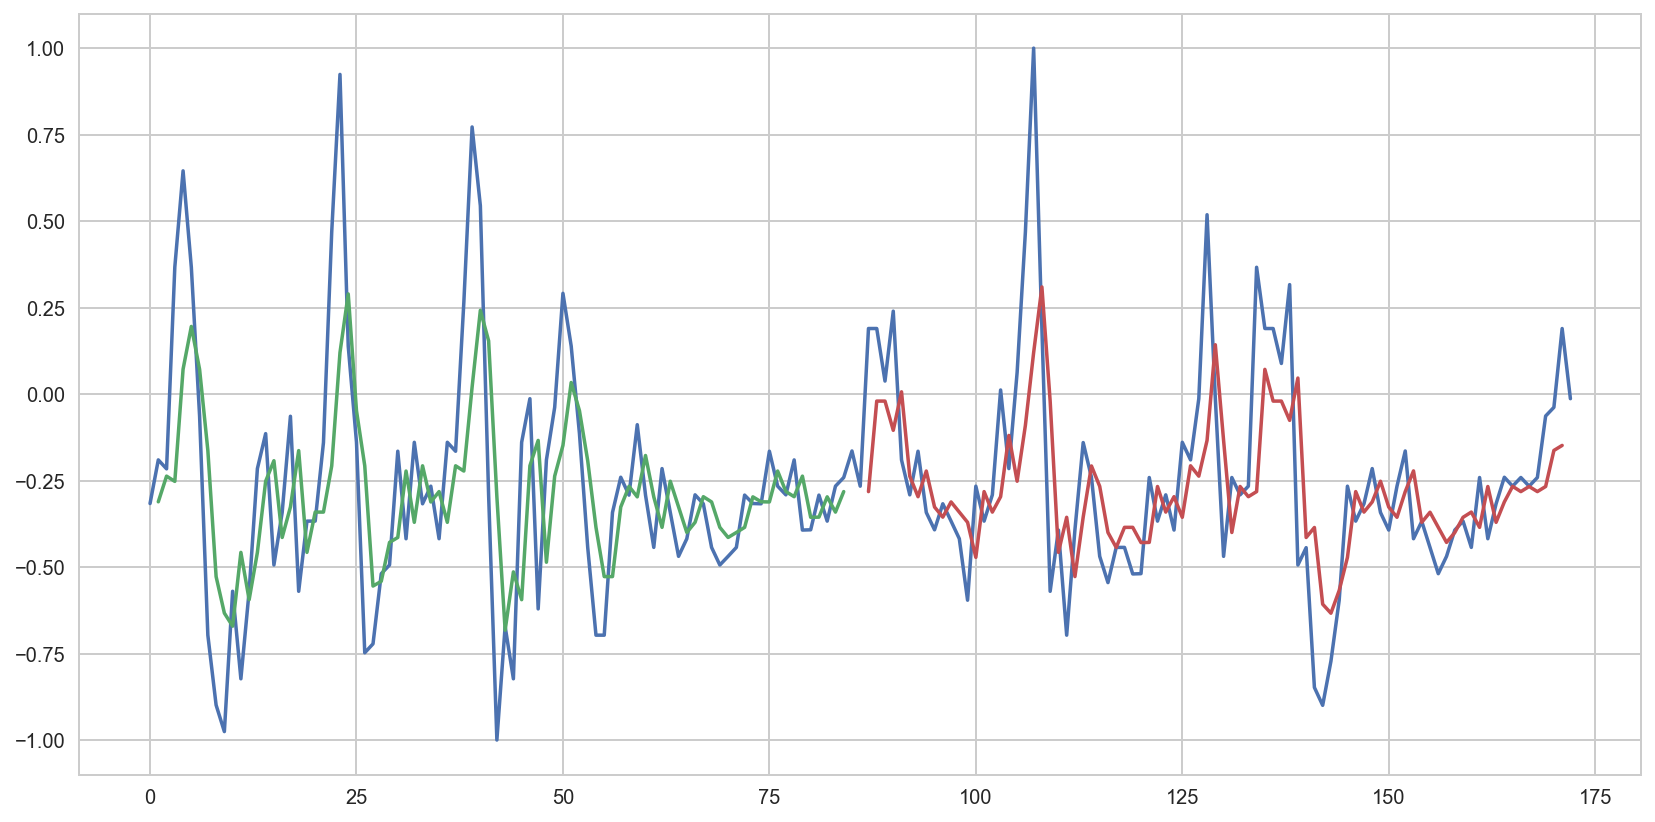

In [41]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(urate)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(urate)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(urate)-1, :] = testPredict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(urate)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

---

### LSTM with multiple lags as predictors

We can instead  predict the unemployment rate from not just the rate prior, but the `t-1`, `t-2`, and `t-3` rates.

You can use the function you wrote above to construct a new X and Y where X now has 3 predictors according to the different lags.

Create the new Y and X variables below:

In [42]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print trainX[0:5]

[[[-0.31636916 -0.19027725 -0.2161033 ]]

 [[-0.19027725 -0.2161033   0.36726168]]

 [[-0.2161033   0.36726168  0.64527155]]

 [[ 0.36726168  0.64527155  0.36650209]]

 [[ 0.64527155  0.36650209 -0.06342575]]]


In [44]:
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.fit(trainX, trainY, nb_epoch=20, batch_size=1, verbose=1)

Epoch 1/20
82/82 [==============================] - 2s - loss: 0.1890     
Epoch 2/20
82/82 [==============================] - 0s - loss: 0.1509     
Epoch 3/20
82/82 [==============================] - 0s - loss: 0.1286     
Epoch 4/20
82/82 [==============================] - 0s - loss: 0.1155     
Epoch 5/20
82/82 [==============================] - 0s - loss: 0.1087     
Epoch 6/20
82/82 [==============================] - 0s - loss: 0.1039     
Epoch 7/20
82/82 [==============================] - 0s - loss: 0.1002     
Epoch 8/20
82/82 [==============================] - 0s - loss: 0.0967     
Epoch 9/20
82/82 [==============================] - 0s - loss: 0.0937     
Epoch 10/20
82/82 [==============================] - 0s - loss: 0.0908     
Epoch 11/20
82/82 [==============================] - 0s - loss: 0.0880     
Epoch 12/20
82/82 [==============================] - 0s - loss: 0.0853     
Epoch 13/20
82/82 [==============================] - 0s - loss: 0.0826     
Epoch 14/20
82/82 [==

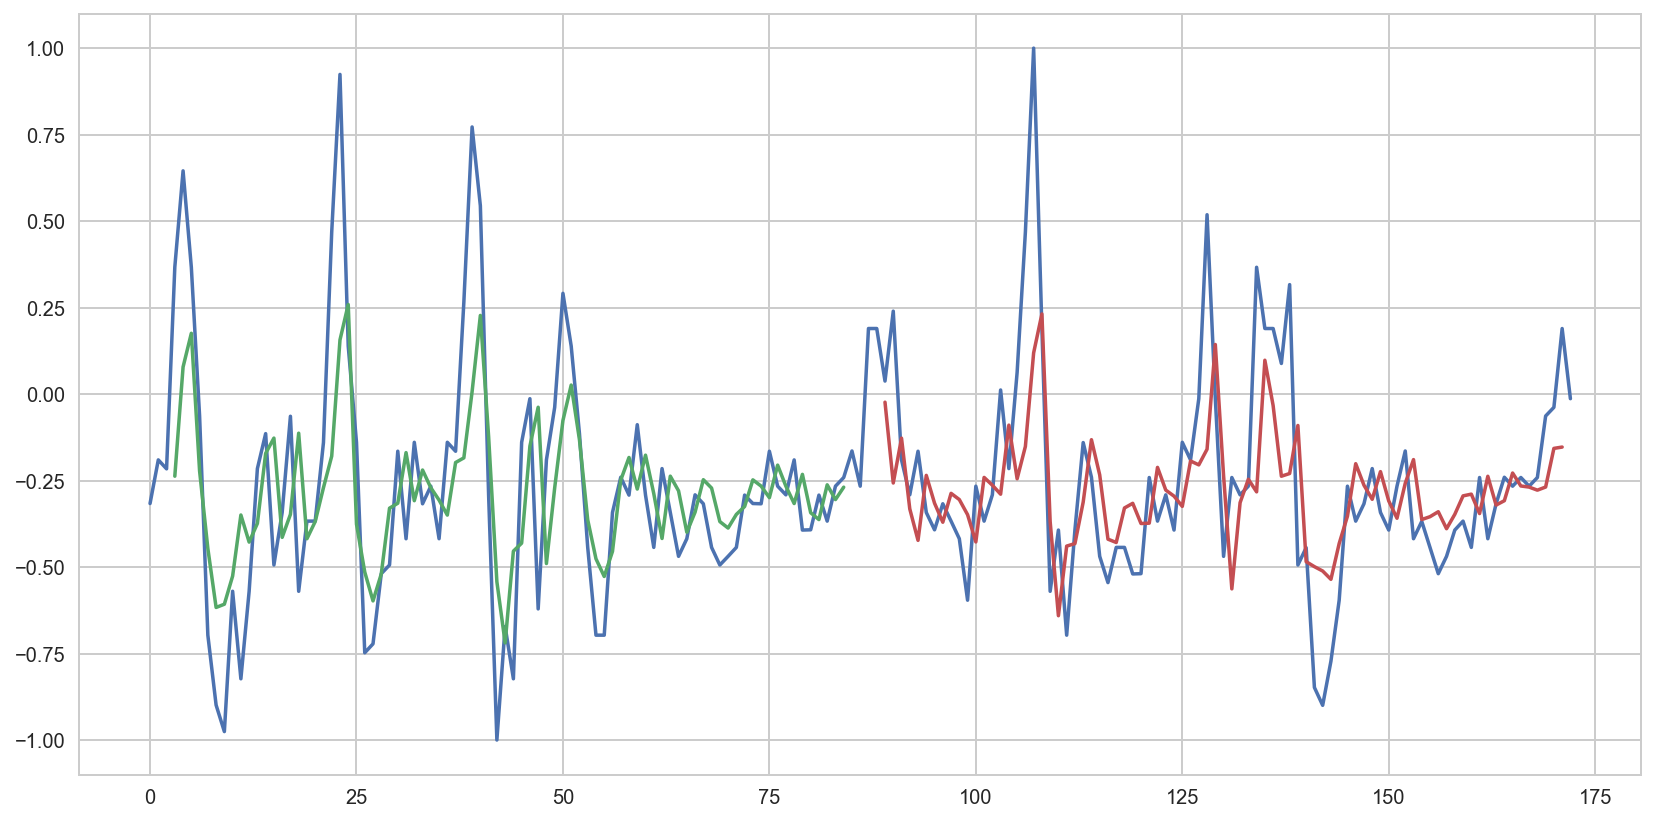

In [45]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(urate)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(urate)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(urate)-1, :] = testPredict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(urate)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

---

### Rephrasing the problem with the "time steps" dimension

Recall that our X matrix is converted to the form:

    [samples, time steps, features]
    
In the model we just made, we were saying that we had 3 different features, each of 1 time step long. This works fine, but it would be more appropriate to say that we had 1 feature with three different time steps, since that's what the data actually is (the unemplyment rate lagged to different degrees).

Instead of reshaping our data where the time step dimension is 1, we can instead reshape it so that the feature dimension is 1 and the time step dimension is 3, like so:

```python
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
```

In this toy example, this will for all intents and purposes be the same, but it is more appropriate to specify it this way since the variable is the same.

Recreate your training and testing data but reshaping your lags on the time dimension rather than the feature dimension:

In [46]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [47]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [48]:
print trainX.shape

(82, 3, 1)


---

### Rebuild and fit the LSTM model, and plot the predictions

In [50]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.fit(trainX, trainY, nb_epoch=20, batch_size=1, verbose=1)

Epoch 1/20
82/82 [==============================] - 3s - loss: 0.1547     
Epoch 2/20
82/82 [==============================] - 1s - loss: 0.1383     
Epoch 3/20
82/82 [==============================] - 1s - loss: 0.1340     
Epoch 4/20
82/82 [==============================] - 1s - loss: 0.1318     
Epoch 5/20
82/82 [==============================] - 1s - loss: 0.1299     
Epoch 6/20
82/82 [==============================] - 0s - loss: 0.1273     
Epoch 7/20
82/82 [==============================] - 1s - loss: 0.1254     
Epoch 8/20
82/82 [==============================] - 1s - loss: 0.1242     
Epoch 9/20
82/82 [==============================] - 1s - loss: 0.1215     
Epoch 10/20
82/82 [==============================] - 0s - loss: 0.1205     
Epoch 11/20
82/82 [==============================] - 1s - loss: 0.1187     
Epoch 12/20
82/82 [==============================] - 1s - loss: 0.1169     
Epoch 13/20
82/82 [==============================] - 1s - loss: 0.1157     
Epoch 14/20
82/82 [==

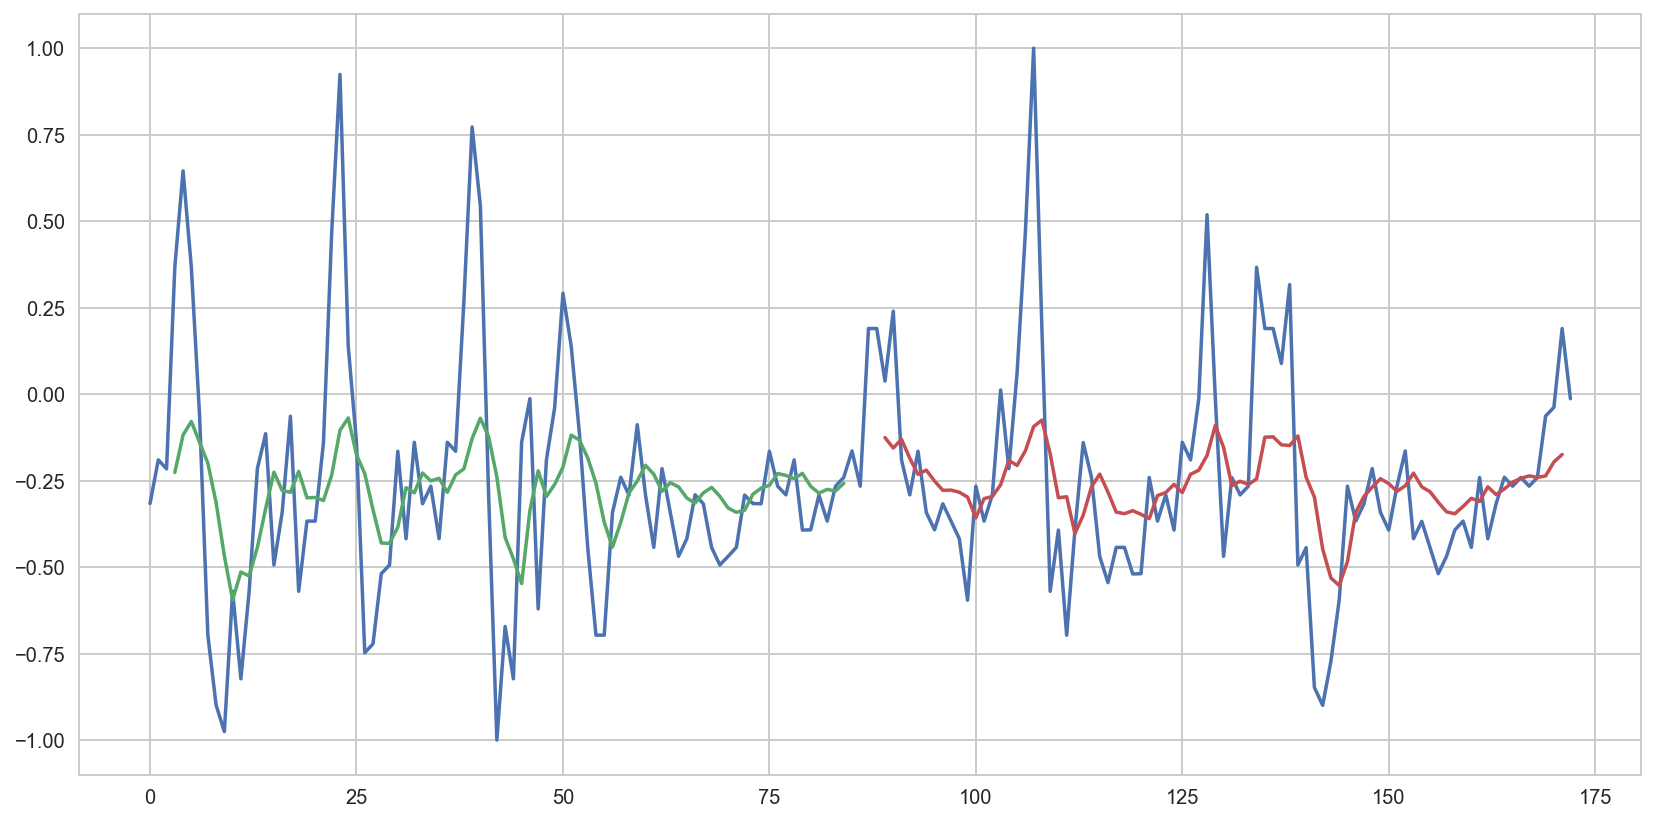

In [51]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(urate)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(urate)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(urate)-1, :] = testPredict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(urate)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

---

### Stateful models

In [53]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [54]:
trainX.shape

(84, 1, 1)

In [55]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [56]:
for i in range(20):
    model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Epoch 1/1
84/84 [==============================] - 2s - loss: 0.1331     
Epoch 1/1
84/84 [==============================] - 0s - loss: 0.1166     
Epoch 1/1
84/84 [==============================] - 0s - loss: 0.1144     
Epoch 1/1
84/84 [==============================] - 0s - loss: 0.1120     
Epoch 1/1
84/84 [==============================] - 0s - loss: 0.1094     
Epoch 1/1
84/84 [==============================] - 0s - loss: 0.1068     
Epoch 1/1
84/84 [==============================] - 0s - loss: 0.1043     
Epoch 1/1
84/84 [==============================] - 0s - loss: 0.1019     
Epoch 1/1
84/84 [==============================] - 0s - loss: 0.0995     
Epoch 1/1
84/84 [==============================] - 0s - loss: 0.0973     
Epoch 1/1
84/84 [==============================] - 0s - loss: 0.0951     
Epoch 1/1
84/84 [==============================] - 0s - loss: 0.0930     
Epoch 1/1
84/84 [==============================] - 0s - loss: 0.0911     
Epoch 1/1
84/84 [=====================

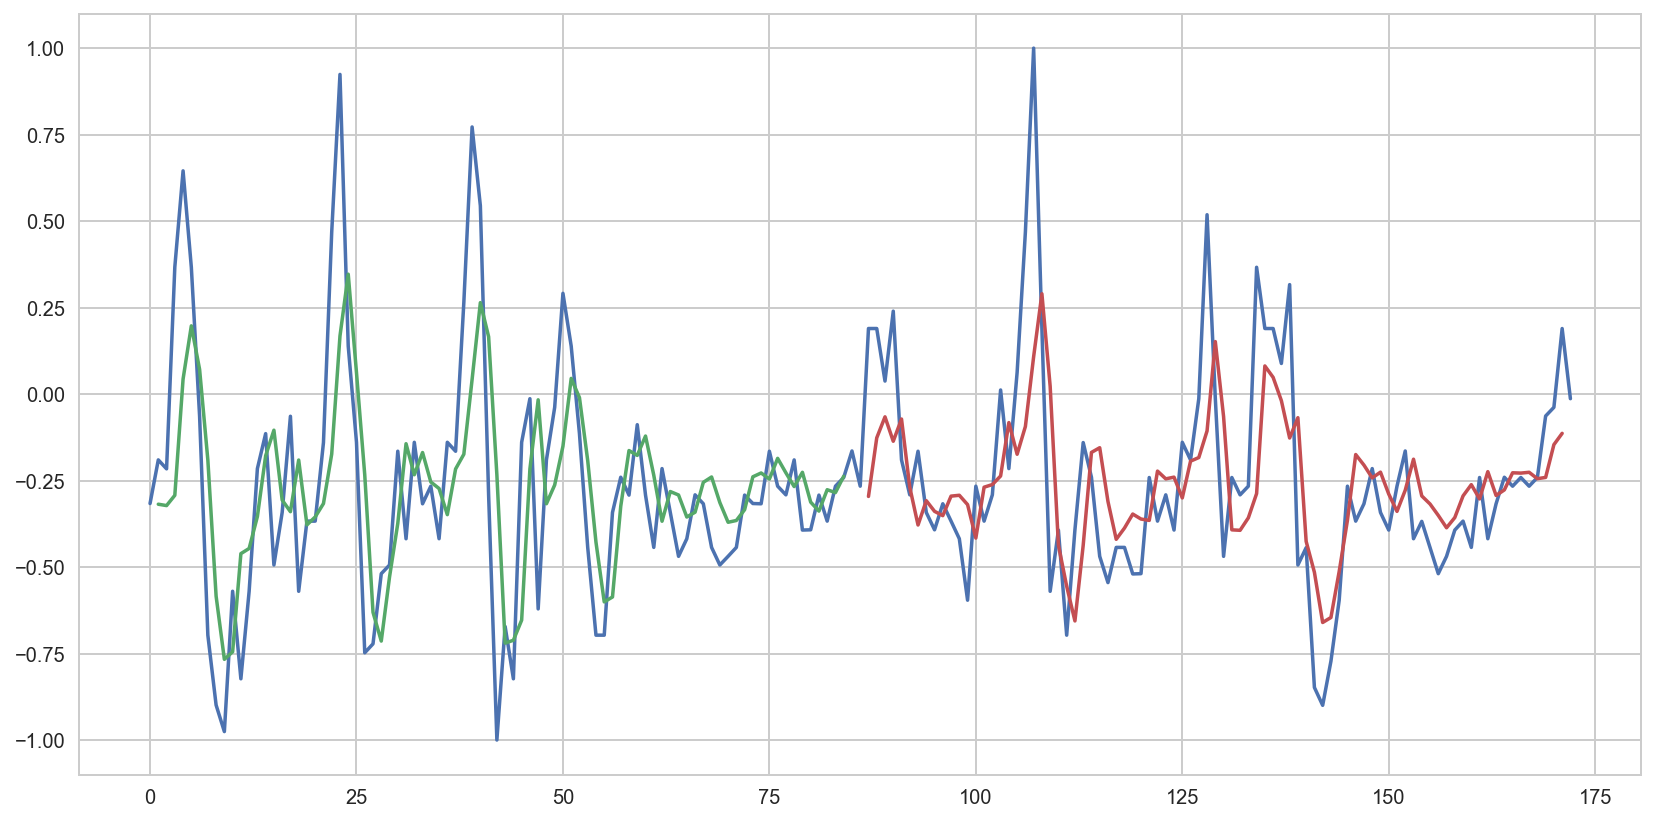

In [57]:
# generate predictions for training
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
model.reset_states()

# shift train predictions for plotting
trainPredictPlot = np.empty_like(urate)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(urate)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(urate)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(urate)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()